In [1]:
import pickle
import numpy as np
import lightgbm as lgb

In [2]:
distance_func = lambda d: d

In [3]:
def get_data(path: str):
    with open(path, "rb") as f:
        json_data = pickle.load(f)
        
    X = []
    y = []

    for k, v in json_data.items():
        print(k)
        node_num, minterm_num = k
        for d_tuple, size in v.items():
            distance = sum(map(distance_func, d_tuple))
            if [node_num, minterm_num, distance] in X:
                index = X.index([node_num, minterm_num, distance])
                y[index] += size
            else:
                X.append([node_num, minterm_num, distance])
                y.append([np.mean(size)])
    
    y = list(map(lambda l: np.mean(l), y))

    X = np.array(X)
    y = np.array(y)
    
    data = np.concatenate((X, y.reshape(-1, 1)), axis=1)
    
    return data
        

In [4]:
data = get_data("distance_size_full.pkl")

(2, 2)
(2, 3)
(3, 2)
(3, 3)
(3, 4)
(3, 5)
(3, 6)
(3, 7)
(4, 2)
(4, 3)
(4, 4)
(4, 5)
(4, 6)
(4, 7)
(4, 8)
(4, 9)
(4, 10)
(4, 12)
(4, 15)
(5, 2)
(5, 3)
(5, 4)
(5, 5)
(5, 6)
(5, 7)
(5, 8)
(5, 9)
(5, 10)
(5, 12)
(5, 15)
(5, 20)
(5, 30)
(6, 2)
(6, 3)
(6, 4)
(6, 5)
(6, 6)
(6, 7)
(6, 8)
(6, 9)
(6, 10)
(6, 12)
(6, 15)
(6, 20)
(6, 30)
(6, 40)
(6, 50)
(7, 2)
(7, 3)
(7, 4)
(7, 5)
(7, 6)
(7, 7)
(7, 8)
(7, 9)
(7, 10)
(7, 12)
(7, 15)
(7, 20)
(7, 30)
(7, 40)
(7, 50)
(8, 2)
(8, 3)
(8, 4)
(8, 5)
(8, 6)
(8, 7)
(8, 8)
(8, 9)
(8, 10)
(8, 12)
(8, 15)
(8, 20)
(8, 30)
(8, 40)
(8, 50)
(9, 2)
(9, 3)
(9, 4)
(9, 5)
(9, 6)
(9, 7)
(9, 8)
(9, 9)
(9, 10)
(9, 12)
(9, 15)
(9, 20)
(9, 30)
(9, 40)
(9, 50)
(10, 2)
(10, 3)
(10, 4)
(10, 5)
(10, 6)
(10, 7)
(10, 8)
(10, 9)
(10, 10)
(10, 12)
(10, 15)
(10, 20)
(10, 30)
(10, 40)
(10, 50)
(12, 2)
(12, 3)
(12, 4)
(12, 5)
(12, 6)
(12, 7)
(12, 8)
(12, 9)
(12, 10)
(12, 12)
(12, 15)
(12, 20)
(12, 30)
(12, 40)
(12, 50)
(15, 2)
(15, 3)
(15, 4)
(15, 5)
(15, 6)
(15, 7)
(15, 8)
(15, 9)
(1

In [5]:
from sklearn.model_selection import train_test_split
import pandas as pd

cols = ["node_num", "minterm_num", "distance", "size"]

data = pd.DataFrame(data, columns=cols)

data_train, data_test = train_test_split(data, test_size=0.2, random_state=23)


In [6]:
from sklearn.metrics import make_scorer

def relative_error(y_true, y_pred):
    return sum(np.abs(y_true - y_pred) / y_true)

my_scorer = make_scorer(relative_error, greater_is_better=False)



In [30]:
from hypergbm import make_experiment

# experiment = make_experiment(data_train, target="size", max_trials=300, cv=True, num_folds=5)
experiment = make_experiment(data_train, target="size", max_trials=100, early_stopping_rounds=20, reward_metric=relative_error, 
                             scorer=my_scorer, num_folds=5)
estimator = experiment.run()
print(estimator)

ExperimentProcessWidget(initData='{"task": "regression", "datasets": [{"kind": "Train", "task": "regression", …

Pipeline(steps=[('data_clean',
                 DataCleanStep(cv=True,
                               data_cleaner_args={'correct_object_dtype': True,
                                                  'drop_columns': None,
                                                  'drop_constant_columns': True,
                                                  'drop_duplicated_columns': False,
                                                  'drop_idness_columns': True,
                                                  'drop_label_nan_rows': True,
                                                  'int_convert_to': 'float',
                                                  'nan_chars': None,
                                                  'reduce_mem_usage': False,
                                                  'reserve_columns': None},
                               name='data_clean')),
                ('est...
                 GreedyEnsemble(weight=[0.1, 0.15, 0.0, 0.05, 0.0, 0.0, 0.0, 0

In [7]:
def read_pickle(pickle_path: str):
    with open(pickle_path, "rb") as f:
        data = pickle.load(f)

    return data

estimator = read_pickle("model.pkl")

In [8]:
y_test = data_test['size'].to_numpy()
error = (np.abs(estimator.predict(data_test) - y_test)) / y_test
print(np.mean(error))
print(np.std(error))
print(np.max(error))
print(np.min(error))

0.039472457184048466
0.08044328129883048
0.9972933159355918
0.00025340221319934187


In [30]:
mean = np.mean(error)
per95 = np.percentile(error, 95)

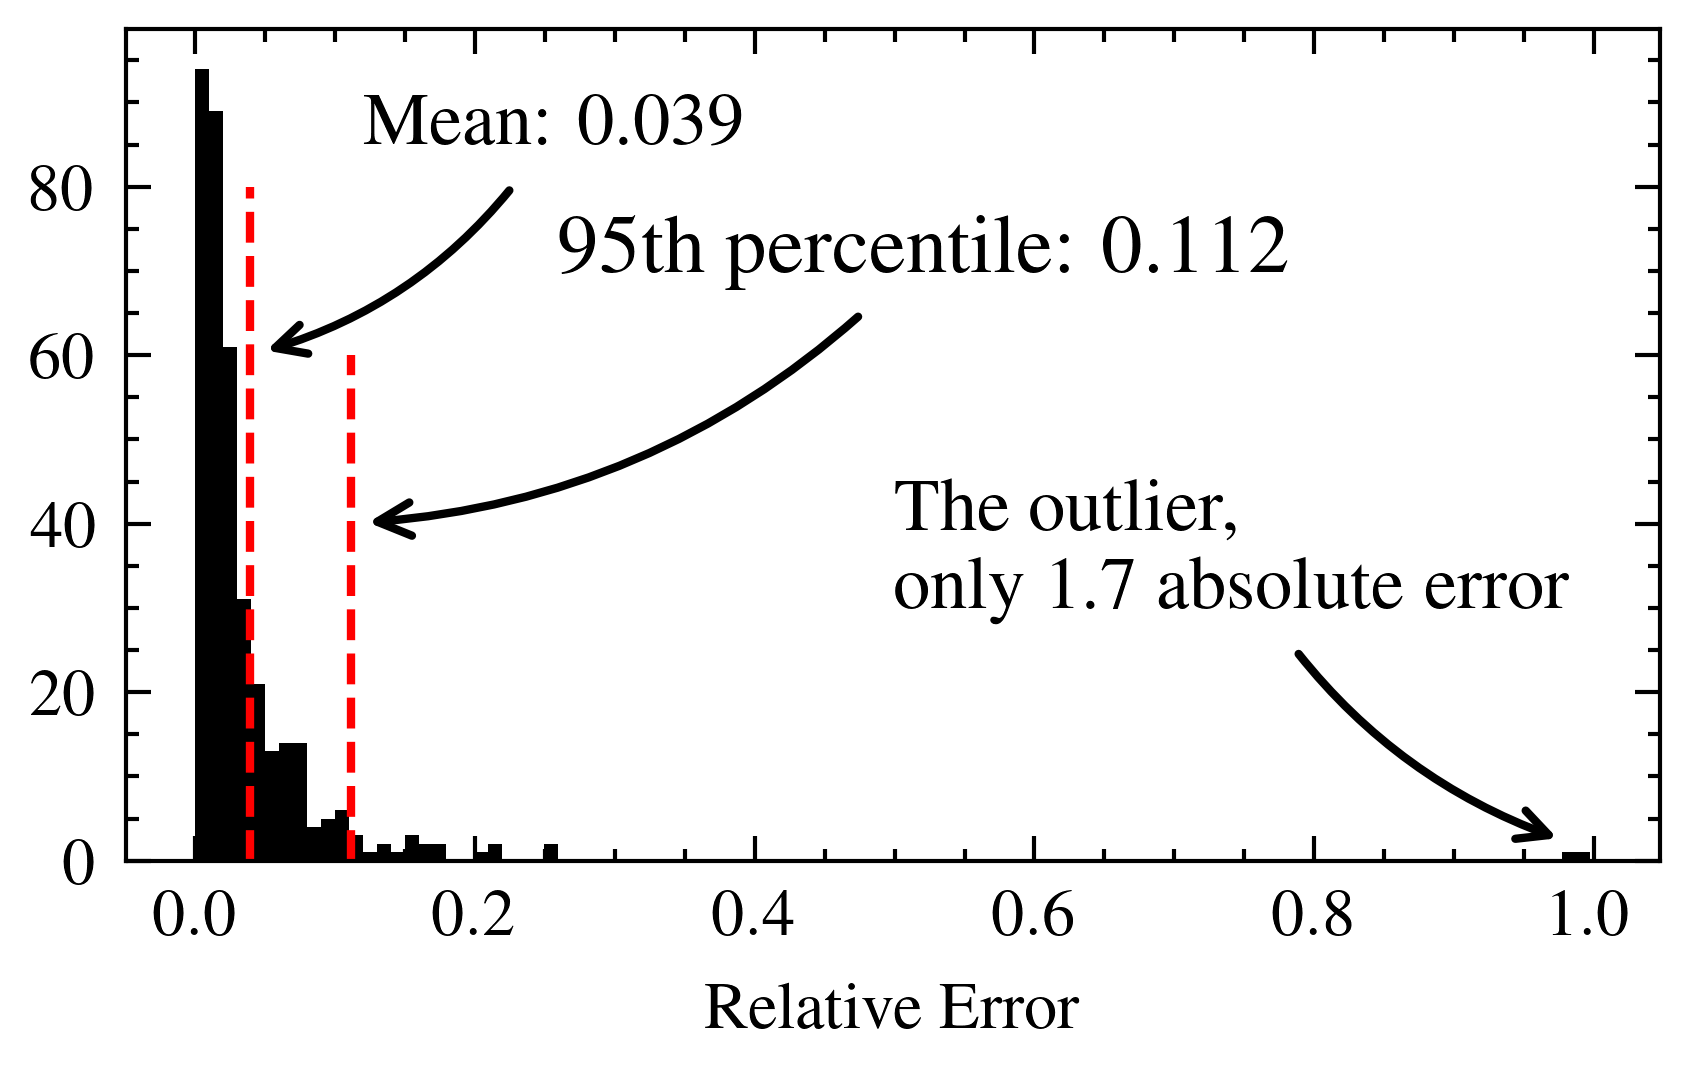

In [51]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import scienceplots

# plt.style.use("seaborn")
plt.style.use(["science", "ieee"])

mpl.rcParams['figure.figsize'] = 3.3, 1.8
mpl.rcParams['font.size'] = 8

fig, ax = plt.subplots()
ax.hist(error, bins=100)
ax.set_xlabel("Relative Error")
# ax.text(0.7, 40, "The outlier with high relative error \n but small absolute error.")
ax.annotate(
    "The outlier, \n only 1.7 absolute error",
    fontsize=9,
    xy=(0.985, 2),
    xytext=(0.5, 30),
    arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=0.2"),
)

# Mean
mean_ = [mean, mean]
y_range = [0, 80]
plt.plot(mean_, y_range, "r--")
ax.annotate(
    f"Mean: {mean:.3f}",
    fontsize=9,
    xy=(mean, 60),
    xytext=(0.12, 85),
    arrowprops=dict(arrowstyle="->", fc="red", connectionstyle="arc3,rad=-0.2")
)

# 95%
zeroone = [per95, per95]
y_range = [0, 60]
plt.plot(zeroone, y_range, "r--")
ax.annotate(
    f"95th percentile: {per95:.3f}",
    fontsize=10,
    xy=(per95, 40),
    xytext=(0.26, 70),
    arrowprops=dict(arrowstyle="->", fc="red", connectionstyle="arc3,rad=-0.2")
)

# ax.set_xscale("log")
# ax.set_ylabel("n")
fig.show()
fig.savefig("relative_error.pdf")


In [24]:
# import pickle
# with open('model.pkl','wb') as f:
#   pickle.dump(estimator, f)

In [25]:
def read_pickle(pickle_path: str):
    with open(pickle_path, "rb") as f:
        data = pickle.load(f)

    return data

estimator = read_pickle("model.pkl")

In [26]:
data_test

,node_num,minterm_num,distance,size
18,4.0,2.0,8.0,7.615385
1439,12.0,30.0,74.0,160.000000
46,4.0,8.0,8.0,7.120968
363,7.0,10.0,19.0,34.761905
919,9.0,50.0,77.0,156.875000
...,...,...,...,...
813,9.0,12.0,32.0,61.600000
695,9.0,4.0,16.0,25.780000
1729,15.0,20.0,82.0,161.750000
1387,12.0,15.0,41.0,93.900000


In [29]:
cols = ["node_num", "minterm_num", "distance"]

data = pd.DataFrame(
            [[7, 10, 19]],
            columns=cols,
        )
estimator.predict(data)

array([34.1247952])